# L E    ASSIGNMENTO

Your boss wants to create groups of customer types for targeted marketing campaigns, such as sending welcome offers to new customers, coupons to re-engage inactive customers, and special statuses (like gold, silver, platinum) for loyal customers.

- **Objective:**  
    - Create at least 4 customer groups (e.g., new customers, inactive customers, and loyalty statuses: gold, silver, platinum, etc.).
    - Use a clustering algorithm to segment the customers.
    - Provide at least 2 graphical rwepresentations of the resulting groups.

<!-- 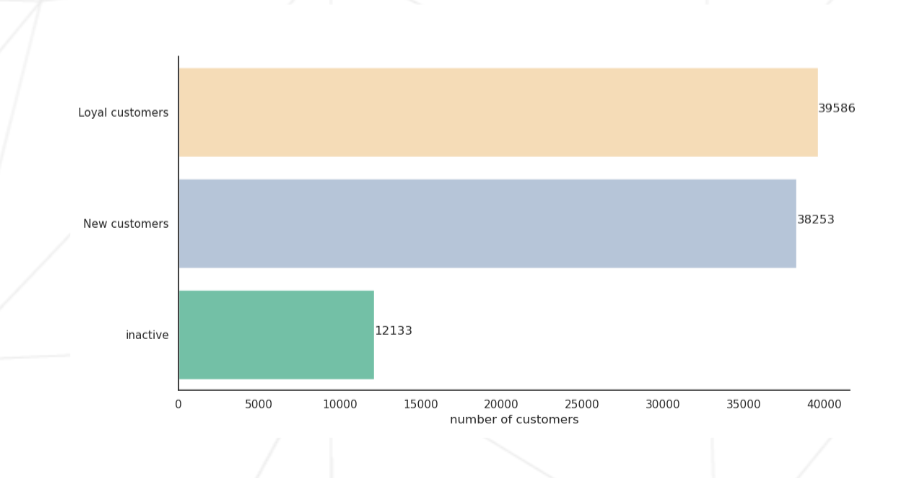

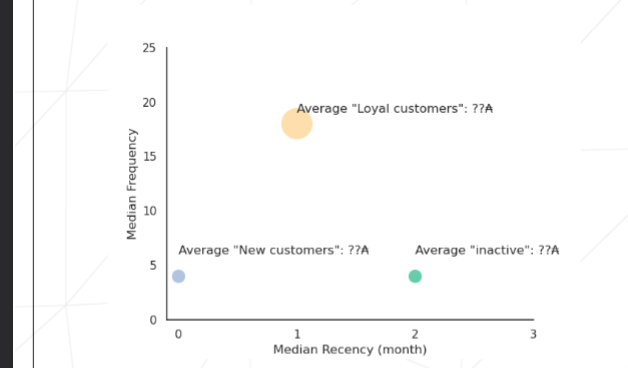

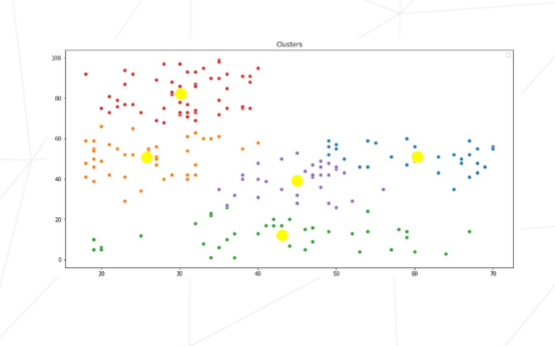

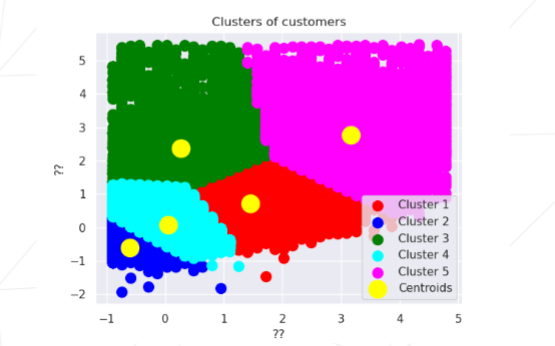 -->

My categories (before k-means)

Loyalty:
- By Purchases
    - Not converted (0 purchases)
    - 1 purchase (New)
    - 2-4 purchases (Occasional)
    - 5-11 purchases (Repeated)
    - 12-14 purchases (Silver)
    - 15-19 purchases (Gold)
    - 20-29 purchases (Epic)
    - 30-39 purchases (Platinum)
    - 40+ purchases (Diamond)

Status:
- By Frequency
- By Recency
    - <30 days
    - 30 - 60 days
    - 60 - 100 days
    - 100 - 140 days
    - 140+ (Inactive)

After K-means:
- 0-3 purchases
- 4-11 purchases
- 12-23 purchases
- 24-39 purchases
- 40-60 purchases
- 61-88 purchases
- 89-128 purchases
- 129-197 purchases
- 198-329 purchases
- 346-713 purchases

In [ ]:
### WHAT IS THIS ASSIGNMENT ABOUT?

This assignment is about using data to group customers into different types for targeted marketing campaigns.

A **customer group** is a set of customers who share similar behaviors or characteristics. For example, some customers might be new, some might not have shopped in a while, and others might be very loyal.

---

### Why do we need to create customer groups?

- If you treat all customers the same, you might miss opportunities to engage them more effectively.
- By grouping customers, you can send the right offers to the right people—like welcoming new customers, re-engaging inactive ones, or rewarding loyal shoppers.

---

### How does the assignment work?

1. Analyze customer data to find patterns in their behavior (like how much they spend, how often they shop, or what they buy).
2. Use a clustering algorithm to automatically group customers based on these patterns.
3. Create at least 4 groups, such as new customers, inactive customers, and loyalty levels (gold, silver, platinum).
4. Visualize the groups with at least 2 different charts to help understand and explain the results.


**Which clustering algorithm should you use?**

A popular and effective algorithm for customer segmentation is **K-Means Clustering**. It automatically groups customers based on similarities in their behavior (like spending, frequency, etc.), and you can specify the number of groups you want (e.g., 4).

Other options include **Hierarchical Clustering** or **DBSCAN**, but K-Means is widely used for its simplicity and interpretability in marketing analytics.

---

### How to explain this to others

> We use data to sort customers into groups based on their shopping habits. This helps us send more personalized offers—like welcoming new shoppers, bringing back those who haven't visited in a while, or giving special rewards to our best customers.


**Structure of the `customers` table:**

| Column Name    | Data Type                                      |
|----------------|------------------------------------------------|
| event_type     | character varying(50)                          |
| product_id     | integer                                        |
| price          | numeric(10,2)                                  |
| user_id        | bigint                                         |
| user_session   | uuid                                           |
| event_time     | timestamp without time zone                    |
| category_id    | bigint                                         |
| category_code  | character varying(255)                         |
| brand          | character varying(255)                         |

In [1]:
import sys
import os

# Add the parent directory to sys.path so we can import CONNECT_TO_DB
notebook_dir = os.getcwd()
sys.path.append(os.path.dirname(notebook_dir))

from CONNECT_TO_DB import setup_connection
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
CLUSTER_NUMBER = 8

In [ ]:
%%python -m ensurepip --upgrade
%pip install sklearn

# BASIC DATA VISU

/tmp/ipykernel_869473/1142497019.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/tmp/ipykernel_869473/1142497019.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=purchase_counts, x='purchase_count', y='user_count', palette='pastel')


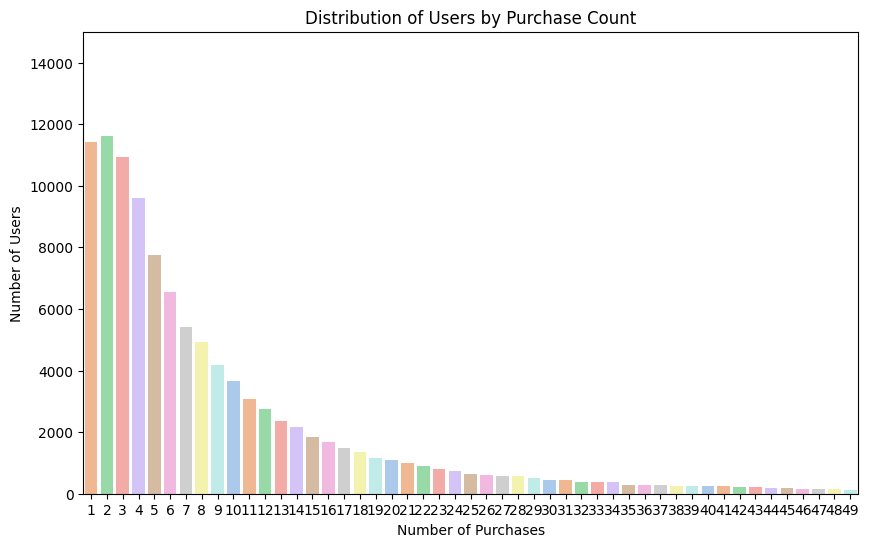

/tmp/ipykernel_869473/1142497019.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=purchase_counts, x='purchase_count', y='user_count', palette='pastel')


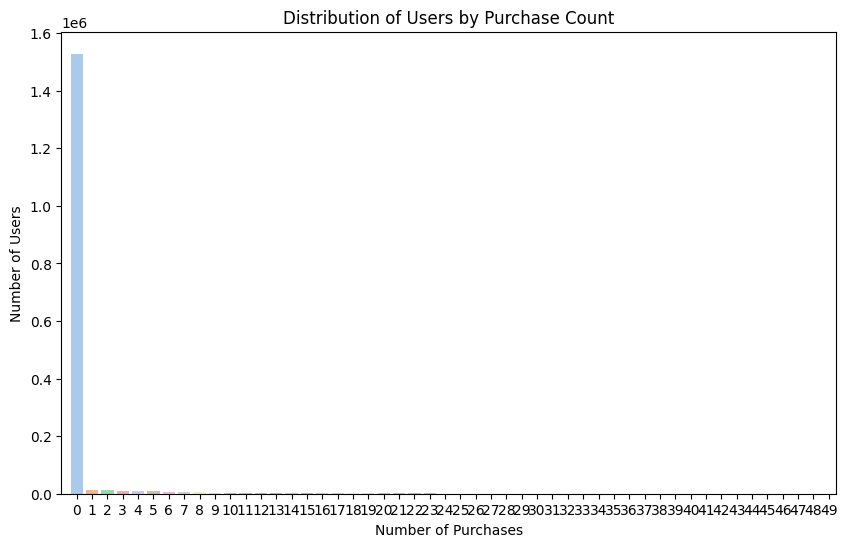

In [2]:
conn = setup_connection()
query = """
SELECT 
    user_id, 
    COUNT(CASE WHEN event_type = 'purchase' THEN event_time END) AS purchase_count
FROM customers
GROUP BY user_id;
"""
df = pd.read_sql(query, conn)

purchase_counts = df['purchase_count'].value_counts().sort_index().reset_index()
purchase_counts.columns = ['purchase_count', 'user_count']

plt.figure(figsize=(10, 6))
sns.barplot(data=purchase_counts, x='purchase_count', y='user_count', palette='pastel')
plt.xlabel('Number of Purchases')
plt.xlim(0.5, 49.5)
plt.ylim(- 0.5, 15000)
plt.ylabel('Number of Users')
plt.title('Distribution of Users by Purchase Count')
plt.show()
plt.figure(figsize=(10, 6))
sns.barplot(data=purchase_counts, x='purchase_count', y='user_count', palette='pastel')
plt.xlabel('Number of Purchases')
# plt.ylim(- 0.5, 15000)
plt.ylabel('Number of Users')
plt.title('Distribution of Users by Purchase Count')
plt.xlim(-1, 49.5)
plt.show()

In [3]:
query = """
WITH session_metrics AS (
    SELECT 
        user_id,
        user_session,
        MIN(event_time) AS session_start,
        MAX(event_time) AS session_end,
        EXTRACT(EPOCH FROM (MAX(event_time) - MIN(event_time)))/60 AS session_length_minutes
    FROM customers
    GROUP BY user_id, user_session
),
user_session_stats AS (
    SELECT 
        user_id,
        COUNT(*) AS session_count,
        AVG(session_length_minutes) AS avg_session_length_minutes,
        MIN(session_start) AS first_session,
        MAX(session_end) AS last_session,
        CASE 
            WHEN COUNT(*) > 1 THEN 
                EXTRACT(EPOCH FROM (MAX(session_end) - MIN(session_start)))/(86400 * (COUNT(*) - 1))
            ELSE 0 
        END AS avg_days_between_sessions
    FROM session_metrics
    GROUP BY user_id
)
SELECT 
    c.user_id, 
    CASE 
        WHEN MAX(CASE WHEN c.event_type = 'purchase' THEN 1 ELSE 0 END) = 1 
        THEN TRUE 
        ELSE FALSE 
    END AS purchased,
    COUNT(CASE WHEN c.event_type = 'purchase' THEN c.event_time END) AS purchase_count,
    uss.session_count,
    MIN(c.event_time) AS first_activity,
    MAX(c.event_time) AS last_activity,
    MIN(CASE WHEN c.event_type = 'purchase' THEN c.event_time END) AS first_purchase,
    MAX(CASE WHEN c.event_type = 'purchase' THEN c.event_time END) AS last_purchase,
    SUM(CASE WHEN c.event_type = 'purchase' THEN c.price ELSE 0 END) AS purchase_total,
    ROUND(uss.avg_session_length_minutes::numeric, 2) AS avg_session_length_minutes,
    ROUND(uss.avg_days_between_sessions::numeric, 2) AS avg_days_between_sessions,
    (DATE '2023-03-31' - uss.last_session::date) AS days_since_last_session
FROM customers c
LEFT JOIN user_session_stats uss ON c.user_id = uss.user_id
GROUP BY c.user_id, uss.session_count, uss.avg_session_length_minutes, uss.avg_days_between_sessions, uss.last_session
ORDER BY avg_days_between_sessions;
"""

In [4]:
conn = setup_connection()
df = pd.read_sql(query, conn)
conn.close()


/tmp/ipykernel_869473/3592400478.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


# K MEANS

In [13]:
from sklearn.cluster import KMeans

# X should be your feature matrix (e.g., df[['purchase_count', 'session_count', ...]])
kmeans = KMeans(n_clusters=CLUSTER_NUMBER, random_state=42)


        purchase_total                      
                   min      max         mean
cluster                                     
0               -10.52    18.16     0.236458
7                18.17    62.96    36.103267
4                62.97   136.23    89.868080
1               136.25   255.86   182.749879
3               255.88   449.64   329.241943
5               449.82   813.52   570.957764
2               816.53  1788.66  1058.211118
6              1843.32  3769.49  2585.560714


/tmp/ipykernel_869473/3797587908.py:34: UserWarning: Mismatched number of handles and labels: len(handles) = 15 len(labels) = 8
  scatter.legend(handles=handles[1:], labels=labels, title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')


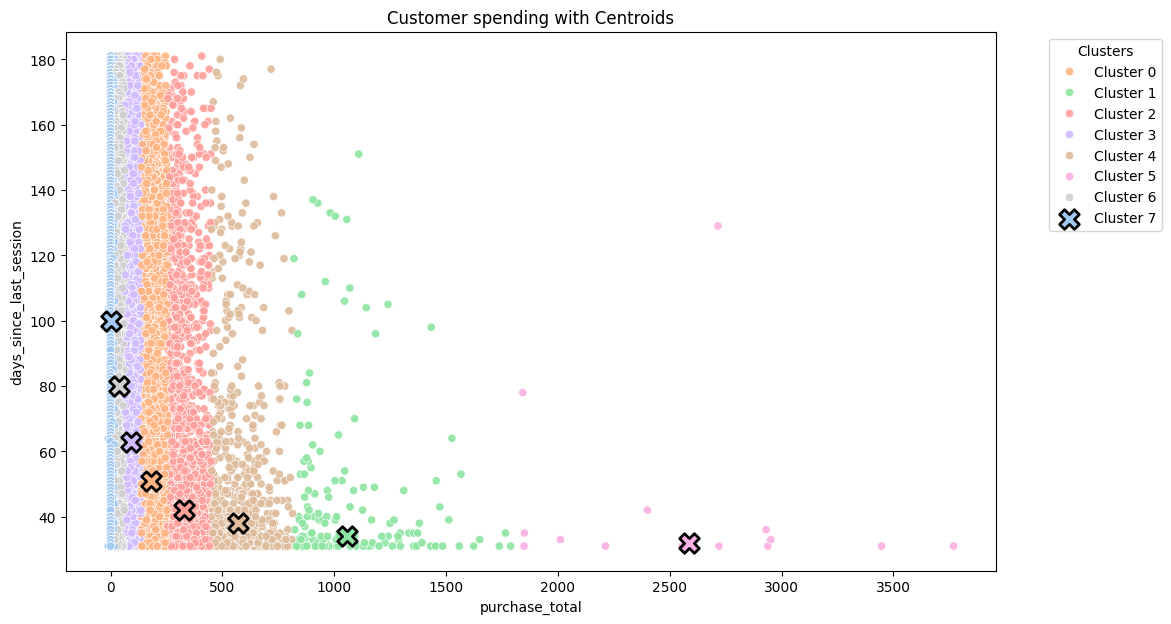

In [40]:
import numpy as np

df['cluster'] = kmeans.fit_predict(df[['purchase_total']])

# Compute cluster summary statistics and sort by min ascending
cluster_summary = df.groupby('cluster').agg({
    'purchase_total': ['min', 'max', 'mean'],
}).sort_values(('purchase_total', 'min'), ascending=True)

labels = [f'Cluster {i}' for i in range(kmeans.n_clusters)]
print(cluster_summary)

plt.figure(figsize=(12, 7))
palette = sns.color_palette('pastel', n_colors=kmeans.n_clusters)
scatter = sns.scatterplot(
    data=df,
    x='purchase_total',
    y='days_since_last_session',
    hue='cluster',
    palette=palette,
    alpha=0.9,
    legend='brief'
)

# Plot centroids
centroids = kmeans.cluster_centers_
for i, c in enumerate(centroids):
    # Use median days_since_last_session for each cluster for y-coordinate
    y = df[df['cluster'] == i]['days_since_last_session'].median()
    plt.scatter(c[0], y, marker='X', s=200, c=[palette[i]], edgecolor='black', linewidth=2, label=f'Centroid {i}')

# Update legend labels
handles, _ = scatter.get_legend_handles_labels()
scatter.legend(handles=handles[1:], labels=labels, title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Customer spending with Centroids')
plt.show()


In [41]:
# SPEND PER CUSTOMER
# for i in range(CLUSTER_NUMBER):
#     cluster_data = df[df['cluster'] == i]
#     print(f"Cluster {i} - Number of users: {len(cluster_data)}")
#     print(f"Cluster {i} - Average spend: {cluster_data['purchase_total'].mean():.2f}")
#     print(f"Cluster {i} - Min spend: {cluster_data['purchase_total'].min():.2f}")
#     print(f"Cluster {i} - Max spend: {cluster_data['purchase_total'].max():.2f}")
#     print(f"Cluster {i} - Average freq: {cluster_data['avg_days_between_sessions'].mean():.2f}")
#     print("-" * 40)

# Create a summary DataFrame for each cluster
summary_list = []
for i in range(CLUSTER_NUMBER):
    cluster_data = df[df['cluster'] == i]
    summary_list.append({
        'cluster': i,
        'num_users': len(cluster_data),
        'avg_spend': cluster_data['purchase_total'].mean(),
        'min_spend': cluster_data['purchase_total'].min(),
        'max_spend': cluster_data['purchase_total'].max(),
        'avg_freq': cluster_data['avg_days_between_sessions'].mean(),
        'total_spend': cluster_data['purchase_total'].sum()
    })

new_df = pd.DataFrame(summary_list)

# Sort by min_spend ascending and reset cluster labels
new_df = new_df.sort_values('min_spend', ascending=True).reset_index(drop=True)
new_df['cluster'] = new_df.index  # reassign cluster numbers

print(new_df)

   cluster  num_users    avg_spend  min_spend  max_spend  avg_freq  \
0        0    1560299     0.236458     -10.52      18.16  2.712426   
1        1      52134    36.103267      18.17      62.96  5.916477   
2        2      17462    89.868080      62.97     136.23  6.381712   
3        3       6258   182.749879     136.25     255.86  6.192908   
4        4       2301   329.241943     255.88     449.64  5.123625   
5        5        729   570.957764     449.82     813.52  4.762689   
6        6        161  1058.211118     816.53    1788.66  3.851739   
7        7         14  2585.560714    1843.32    3769.49  1.030000   

   total_spend  
0    368945.51  
1   1882207.71  
2   1569276.42  
3   1143648.74  
4    757585.71  
5    416228.21  
6    170371.99  
7     36197.85  


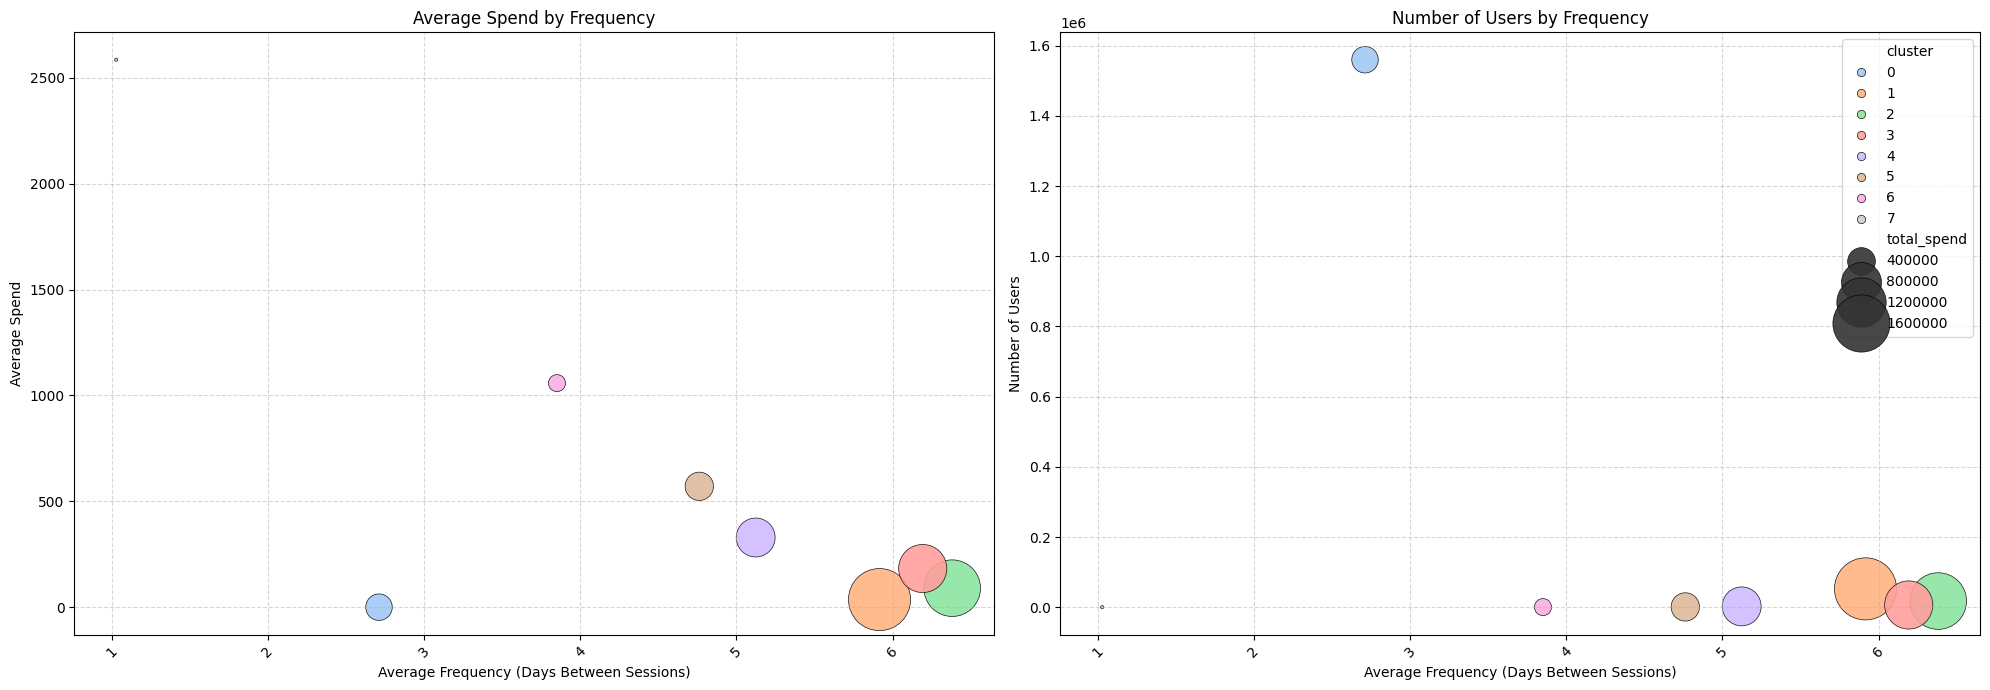

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(20, 7), sharex=True)

# First plot: avg_spend vs avg_freq
sns.scatterplot(
    data=new_df,
    x='avg_freq',
    y='avg_spend',
    hue='cluster',
    size='total_spend',
    sizes=(5, 2000),
    legend=False,
    edgecolor='black',
    linewidth=0.5,
    palette=sns.color_palette('pastel', n_colors=CLUSTER_NUMBER),
    alpha=0.9,
    ax=axes[0]
)
axes[0].set_title('Average Spend by Frequency')
axes[0].set_xlabel('Average Frequency (Days Between Sessions)')
axes[0].set_ylabel('Average Spend')
axes[0].grid(True, linestyle='--', alpha=0.5)
axes[0].tick_params(axis='x', rotation=45)

# Second plot: num_users vs avg_freq
sns.scatterplot(
    data=new_df,
    x='avg_freq',
    y='num_users',
    hue='cluster',
    size='total_spend',
    sizes=(5, 2000),
    legend='brief',
    edgecolor='black',
    linewidth=0.5,
    palette=sns.color_palette('pastel', n_colors=CLUSTER_NUMBER),
    alpha=0.9,
    ax=axes[1]
)
axes[1].set_title('Number of Users by Frequency')
axes[1].set_xlabel('Average Frequency (Days Between Sessions)')
axes[1].set_ylabel('Number of Users')
axes[1].grid(True, linestyle='--', alpha=0.5)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()